In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             classification_report, confusion_matrix,
                             RocCurveDisplay)
from sklearn.calibration import calibration_curve
import shap
import joblib



In [10]:
df = pd.read_csv("maternal_data.csv")

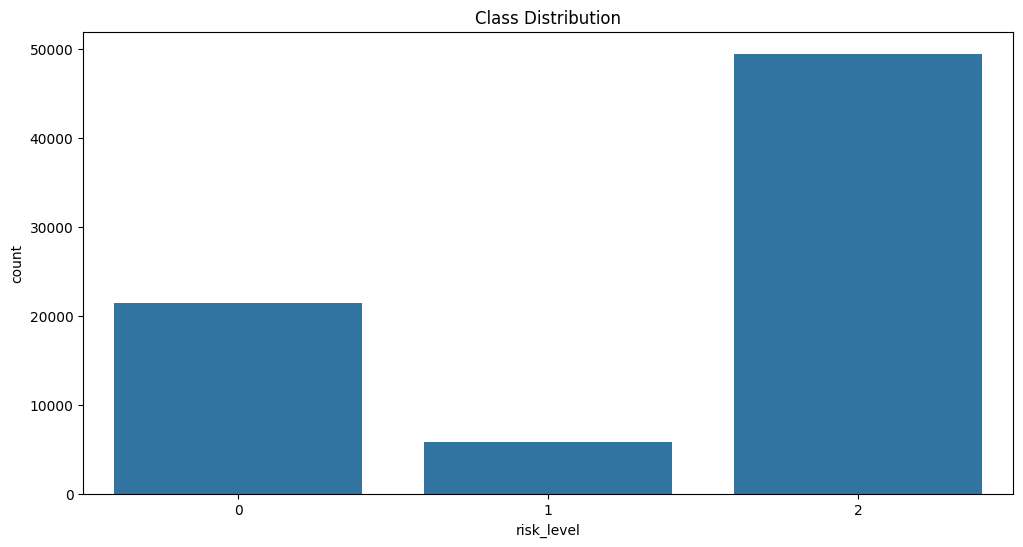

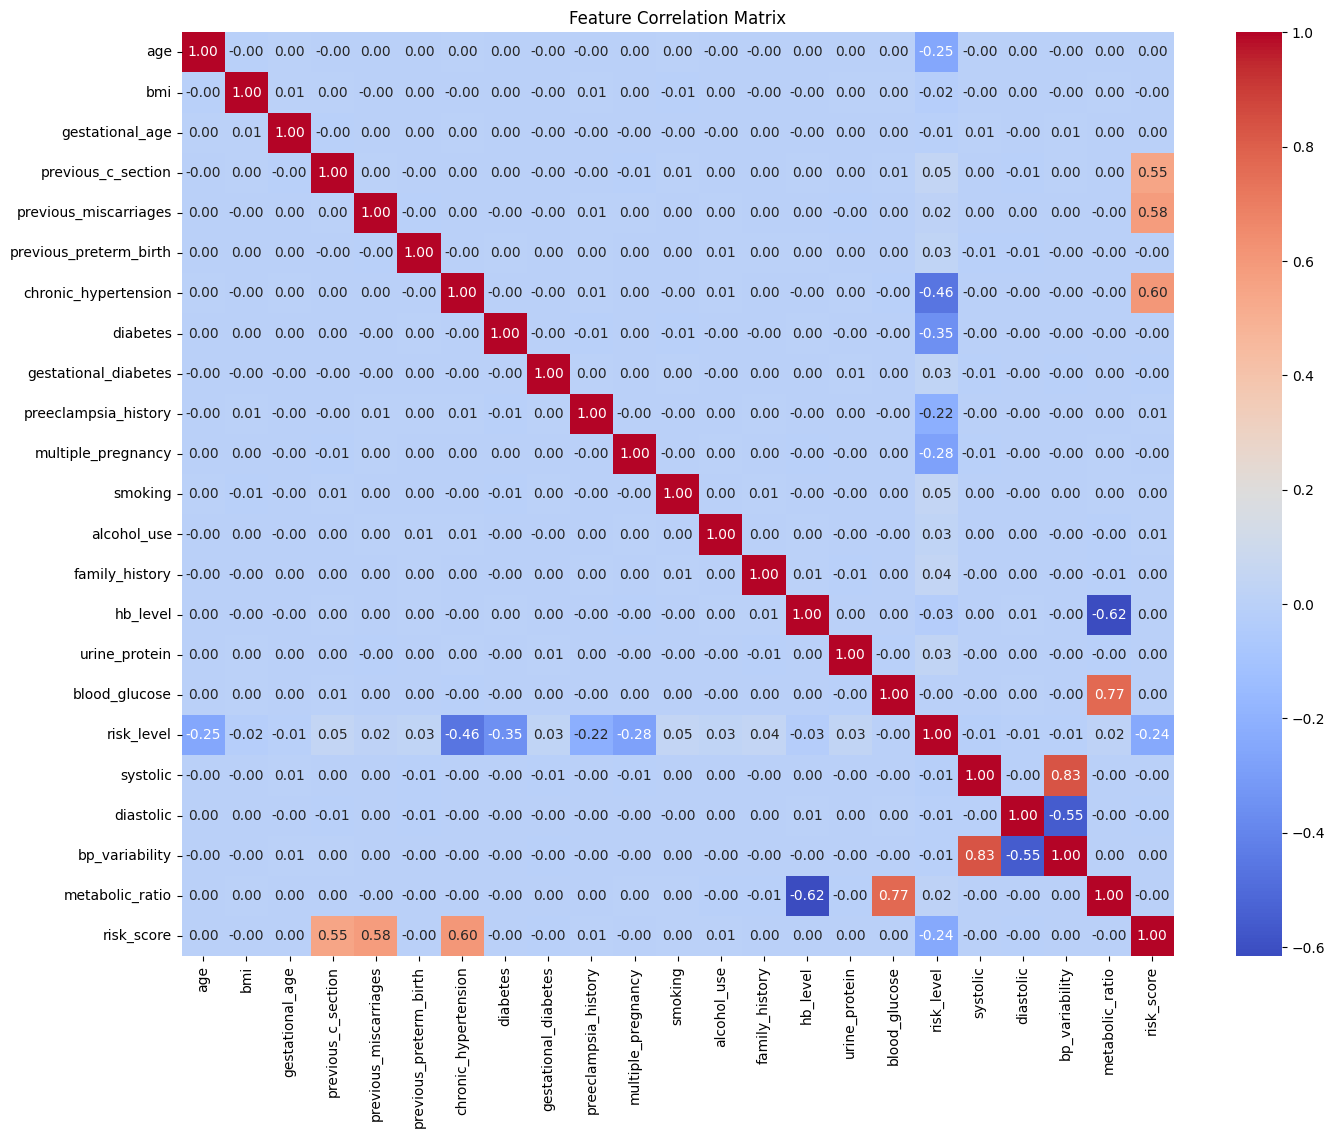

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(x='risk_level', data=df)
plt.title('Class Distribution')
plt.show()

# %%
# Feature engineering
# # df[['systolic', 'diastolic']] = df['blood_pressure'].str.split('/', expand=True).astype(int)
# df['bp_variability'] = df['systolic'] - df['diastolic']
# df['metabolic_ratio'] = df['blood_glucose'] / (df['hb_level'] + 1e-6)
# df['risk_score'] = (df['previous_c_section'] * 0.5 + 
#                    df['previous_miscarriages'] * 0.3 +
#                    df['chronic_hypertension'] * 0.8)
# df.drop('blood_pressure', axis=1, inplace=True)

# Correlation matrix
plt.figure(figsize=(16, 12))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

In [18]:
le = LabelEncoder()
df['risk_level'] = le.fit_transform(df['risk_level'])

# Split data
X = df.drop('risk_level', axis=1)
y = df['risk_level']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from sklearn.ensemble import StackingClassifier

# 1. Define base models and param_grids
xgb = XGBClassifier(objective='multi:softmax')
rf = RandomForestClassifier(class_weight='balanced')
mlp = MLPClassifier(max_iter=1000)
meta_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000)

param_grids = {
    'xgb': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'rf': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20]
    },
    'mlp': {
        'hidden_layer_sizes': [(100,), (50,50)],
        'alpha': [0.0001, 0.001]
    }
}

# 2. Tune models and create best_models
best_models = {}
for name, model in [('xgb', xgb), ('rf', rf), ('mlp', mlp)]:
    print(f"\nTuning {name.upper()}...")
    search = RandomizedSearchCV(
        model, param_grids[name], n_iter=10, cv=3, n_jobs=-1
    )
    search.fit(X_train_scaled, y_train)
    best_models[name] = search.best_estimator_
    # ...plotting code...

# 3. Now define the stacking model using best_models
stack_model = StackingClassifier(
    estimators=[
        ('xgb', best_models['xgb']),
        ('rf', best_models['rf']),
        ('mlp', best_models['mlp'])
    ],
    final_estimator=meta_model,
    stack_method='predict_proba'
)


Tuning XGB...

Tuning RF...


c:\Users\abusa\Desktop\Project\maternal-risk-app\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Tuning MLP...


c:\Users\abusa\Desktop\Project\maternal-risk-app\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [ ]:
best_models = {}
for name, model in [('xgb', xgb), ('rf', rf), ('mlp', mlp)]:
    print(f"\nTuning {name.upper()}...")
    search = RandomizedSearchCV(
        model, param_grids[name], n_iter=10, cv=3, n_jobs=-1
    )
    search.fit(X_train_scaled, y_train)
    best_models[name] = search.best_estimator_
    
    # Plot validation curve
    results = pd.DataFrame(search.cv_results_)
    plt.figure(figsize=(10, 6))
    for param in param_grids[name].keys():
        if results[f'param_{param}'].dtype == 'object': continue
        sns.lineplot(x=f'param_{param}', y='mean_test_score', 
                     data=results, marker='o')
    plt.title(f'{name.upper()} Hyperparameter Tuning')
    plt.xlabel('Parameter Value')
    plt.ylabel('Mean Validation Score')
    plt.show()

In [ ]:
stack_model.fit(X_train_scaled, y_train)

# Evaluation metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    # Classification report
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix(y_test, y_pred), 
                annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, 
                yticklabels=le.classes_)
    plt.title('Confusion Matrix')
    plt.show()
    
    # ROC curves
    fig, ax = plt.subplots(figsize=(10, 8))
    for i, class_name in enumerate(le.classes_):
        RocCurveDisplay.from_predictions(
            (y_test == i).astype(int),
            y_proba[:, i],
            name=f"{class_name} vs Rest",
            ax=ax
        )
    plt.title('ROC Curves')
    plt.show()
    
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred, average='weighted'),
        'roc_auc': roc_auc_score(y_test, y_proba, multi_class='ovr')
    }

# %%
# Evaluate stacking model
metrics = evaluate_model(stack_model, X_test_scaled, y_test)

# Metrics visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
plt.title('Model Performance Metrics')
plt.ylim(0, 1)
plt.show()

In [ ]:
explainer = shap.KernelExplainer(stack_model.predict_proba, X_train_scaled[:100])
shap_values = explainer.shap_values(X_test_scaled[:10])

# Summary plot
shap.summary_plot(shap_values, X_test_scaled[:10], 
                 feature_names=X.columns, 
                 class_names=le.classes_,
                 show=False)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

# %%
# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, 
                                        stack_model.predict_proba(X_test_scaled)[:, 1],
                                        n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Stack Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.title('Calibration Curve')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()

In [ ]:
joblib.dump(stack_model, 'maternal_risk_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')

print("Model artifacts saved successfully!")